<a href="https://colab.research.google.com/github/Emaan10/Elevvo-ML.internshipTasks/blob/main/Music%20Genre%20Classification/Elevvo_Task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Step 1: Download Dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
dataset_path = os.path.join(path, "Data/genres_original")
print("Dataset ready at:", dataset_path)
genres = os.listdir(dataset_path)
print("Available genres:", genres)

Dataset ready at: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
Available genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [ ]:
# Step 2: Feature Extraction (MFCC)
def extract_features(file_path, max_pad_len=174, n_mfcc=40):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception:
        return None

features, labels = [], []
print("\nExtracting MFCC features...")
for idx, genre in enumerate(genres):
    genre_dir = os.path.join(dataset_path, genre)
    for file in os.listdir(genre_dir):
        if file.endswith(".wav"):
            data = extract_features(os.path.join(genre_dir, file))
            if data is not None:
                features.append(data)
                labels.append(genre)

X = np.array(features)
y = np.array(labels)
print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Extracting MFCC features...


/tmp/ipython-input-3851953357.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Features shape: (999, 40, 174)
Labels shape: (999,)


In [ ]:
# Step 3: Encode Labels + Train-Test Split
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(genres))
X = X[..., np.newaxis]  # CNN input shape

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)


In [ ]:
# Step 4: RandomForest Baseline (on flattened MFCCs)
X_rf = X.reshape(len(X), -1)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_rf, y_train_rf)
rf_preds = rf.predict(X_test_rf)
rf_acc = accuracy_score(y_test_rf, rf_preds)
print(f"\nRandomForest Baseline Accuracy: {rf_acc*100:.2f}%")



RandomForest Baseline Accuracy: 47.00%


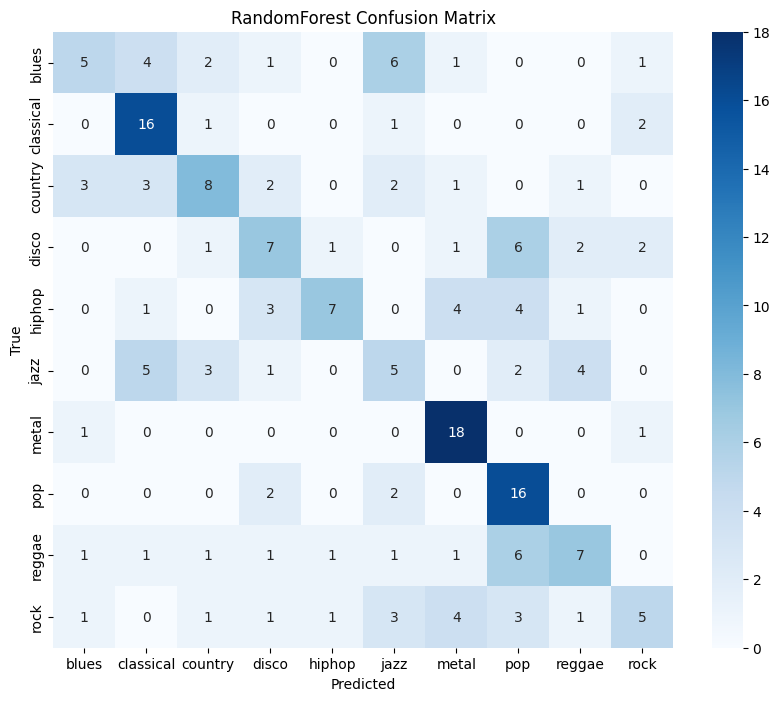

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_rf, rf_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("RandomForest Confusion Matrix")
plt.show()


In [ ]:
# Step 5: CNN Model (Improved)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40, 174, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(genres), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 38, 172, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 17, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 40, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 6, 40, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,062,474 (7.87 MB)

 Trainable params: 2,062,026 (7.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callbacks
callbacks = [ EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3) ]

# Train CNN
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 531ms/step - accuracy: 0.1284 - loss: 6.0226 - val_accuracy: 0.1300 - val_loss: 2.5664 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - accuracy: 0.2500 - loss: 2.1146 - val_accuracy: 0.2050 - val_loss: 2.2449 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 516ms/step - accuracy: 0.2787 - loss: 1.9991 - val_accuracy: 0.1900 - val_loss: 2.2015 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 0.3278 - loss: 1.8786 - val_accuracy: 0.2450 - val_loss: 2.0746 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - accuracy: 0.3578 - loss: 1.7827 - val_accuracy: 0.3100 - val_loss: 1.8360 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.3718 - loss: 1.7320 - val_accuracy: 0.3400 - val_loss: 1.7560 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.4054 - loss: 1.

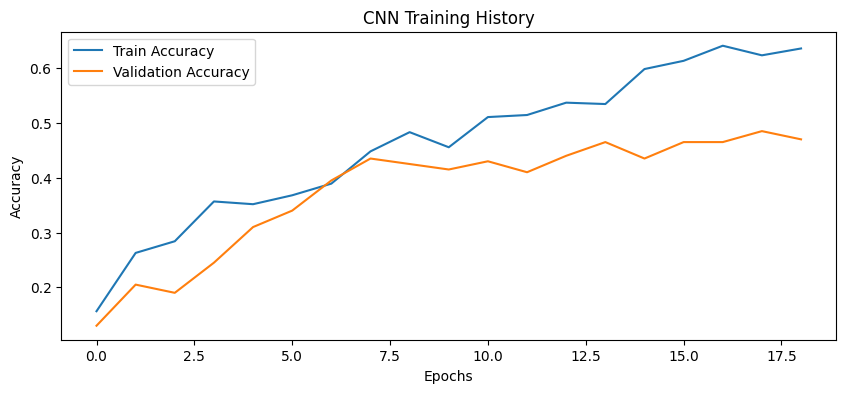

In [ ]:
# Plot Training History
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training History")
plt.show()

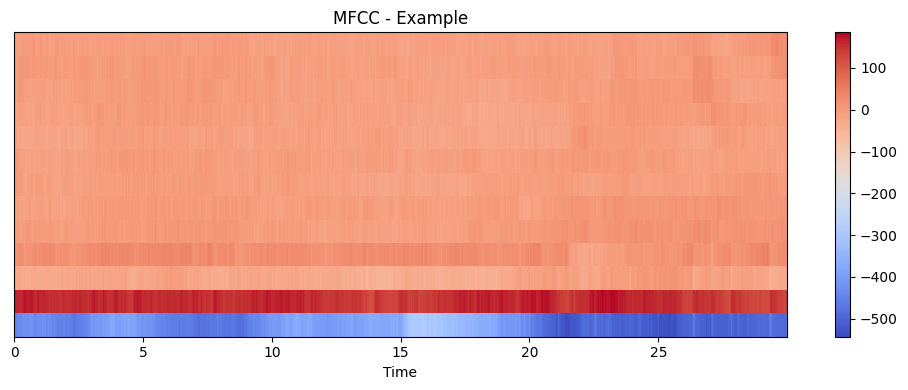

In [ ]:
# Step 6: Visualization Examples (Spectrogram + MFCC)
example_audio = os.path.join(dataset_path, "classical", os.listdir(os.path.join(dataset_path, "classical"))[0])
y, sr = librosa.load(example_audio, duration=30)

# MFCC
plt.figure(figsize=(10, 4))
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCC - Example")
plt.tight_layout()
plt.show()

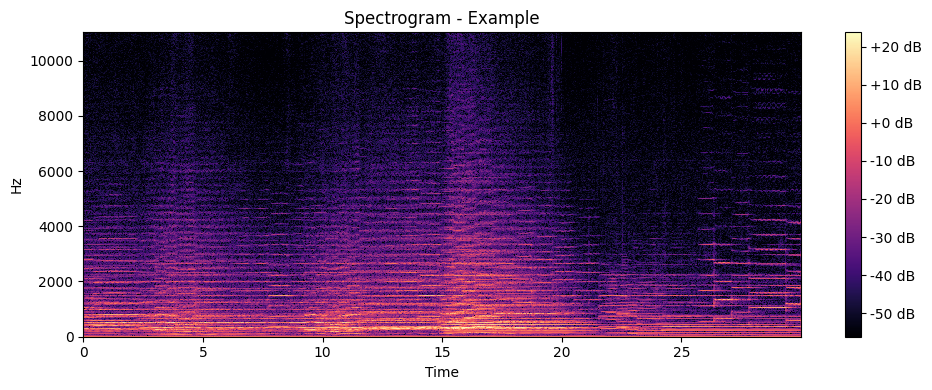

In [ ]:
# Spectrogram
plt.figure(figsize=(10, 4))
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(S))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram - Example")
plt.tight_layout()
plt.show()